In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
allocs = pd.Series([.05, .3, .35, .3, 1], index=['CL', 'ES', 'GC', 'NQ', 'total'])
cash = 100000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-02-15_14-10_20190101_20191031.csv')
del df['sys_time']
del df['reports']
del df['exec_ids']
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df

,contract,action,amount,price,order_id,reason,commission,realizedPNL,cash
time,,,,,,,,,
2019-01-21 03:47:00,CL,BUY,1,54.128,1,entry,2.37,0.00,100000.00
2019-01-21 09:29:00,CL,SELL,1,53.843,2,stop-out,2.37,-289.74,99710.26
2019-01-21 09:49:00,GC,SELL,4,1277.910,3,entry,9.68,0.00,99710.26
2019-01-21 15:40:00,GC,BUY,4,1279.710,4,stop-out,9.68,-739.36,98970.90
2019-01-21 16:11:00,CL,BUY,1,54.278,5,entry,2.37,0.00,98970.90
...,...,...,...,...,...,...,...,...,...
2019-10-30 19:35:00,GC,SELL,3,1486.320,1567,entry,7.26,0.00,202451.51
2019-10-30 19:45:00,GC,BUY,3,1487.220,1568,stop-out,7.26,-284.52,202166.99
2019-10-30 20:24:00,ES,BUY,2,3047.250,1569,entry,4.20,0.00,202166.99


In [4]:
df[(df['contract'] == 'GC') & (df['realizedPNL'] == 0)].count()

contract       213
action         213
amount         213
price          213
order_id       213
reason         213
commission     213
realizedPNL    213
cash           213
dtype: int64

In [5]:
df[df['contract'] == 'GC']

,contract,action,amount,price,order_id,reason,commission,realizedPNL,cash
time,,,,,,,,,
2019-01-21 09:49:00,GC,SELL,4,1277.910000,3,entry,9.68,0.00,99710.26
2019-01-21 15:40:00,GC,BUY,4,1279.710000,4,stop-out,9.68,-739.36,98970.90
2019-01-22 09:51:00,GC,BUY,4,1289.040735,7,entry,9.68,0.00,98626.16
2019-01-22 13:01:00,GC,SELL,4,1287.122774,8,stop-out,9.68,-786.54,97839.62
2019-01-22 19:08:00,GC,BUY,4,1289.653278,15,entry,9.68,0.00,97569.88
...,...,...,...,...,...,...,...,...,...
2019-10-30 16:31:00,GC,BUY,3,1496.800000,1565,entry,7.26,0.00,203875.77
2019-10-30 19:00:00,GC,SELL,3,1492.970000,1566,stop-out,7.26,-1163.52,202712.25
2019-10-30 19:35:00,GC,SELL,3,1486.320000,1567,entry,7.26,0.00,202451.51


In [6]:
df.groupby('contract').realizedPNL.sum()

contract
CL     6069.81
ES    22235.08
GC    41567.84
NQ    32294.26
Name: realizedPNL, dtype: float64

In [7]:
df.realizedPNL.sum()

102166.99

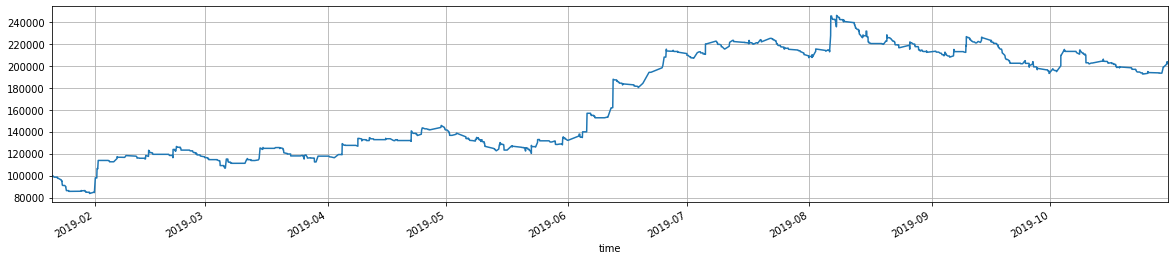

In [8]:
df.cash.plot(figsize=(20,4), grid=True);

In [9]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [10]:
# number of trades
trades = df.groupby('contract').action.count()
trades

contract
CL    402
ES    145
GC    425
NQ    391
Name: action, dtype: int64

In [11]:
# commission paid
df.groupby('contract').commission.sum()

contract
CL     952.74
ES     886.20
GC    3351.70
NQ    1936.20
Name: commission, dtype: float64

In [12]:
df.commission.sum()

7126.84

In [13]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
CL,0.23,30.20,1147.62,-301.42,3.81,31.86,201.0
GC,0.24,196.07,3452.21,-808.91,4.27,213.76,212.0
NQ,0.22,165.61,3958.66,-907.42,4.36,163.12,195.0
ES,0.43,308.82,3528.97,-2125.93,1.66,305.68,72.0


In [14]:
daily = by_contract.resample('B').sum()
daily = daily.cumsum() +  (allocs * cash)
#daily[['CLZ9', 'ESZ9', 'GCZ9', 'NQZ9']].plot(figsize=(20,8), grid=True);

In [15]:
log_returns = np.log(daily.pct_change()[1:] + 1)
log_returns.corr()

contract,CL,ES,GC,NQ,total
contract,,,,,
CL,1.000000,0.062900,-0.045328,-0.019145,0.125133
ES,0.062900,1.000000,0.139896,0.312676,0.629372
GC,-0.045328,0.139896,1.000000,0.122251,0.667170
NQ,-0.019145,0.312676,0.122251,1.000000,0.701591
total,0.125133,0.629372,0.667170,0.701591,1.000000


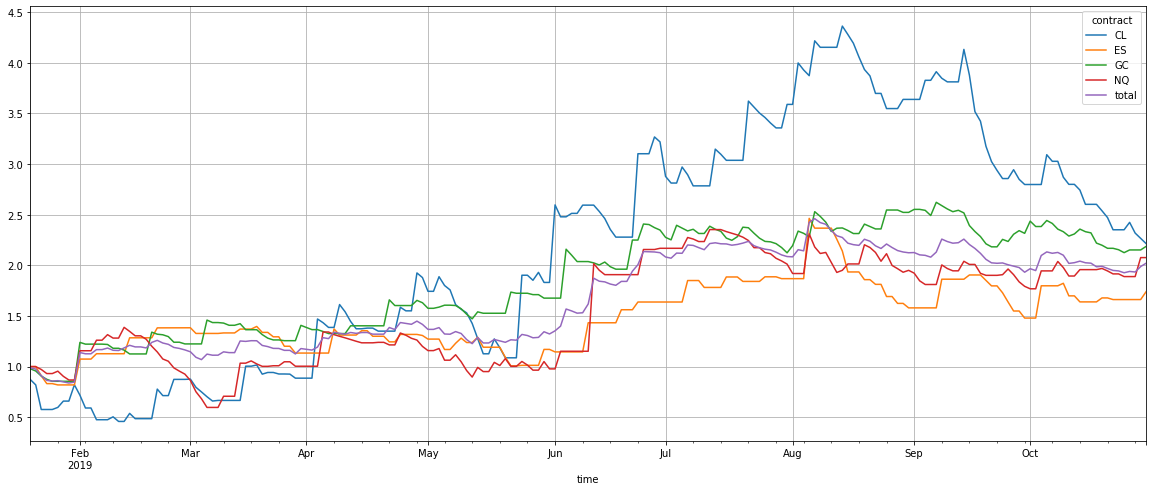

In [16]:
returns = daily.pct_change()
returns.iloc[0] = (daily.iloc[0] / (allocs * cash))-1
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [17]:
stats = pd.DataFrame()
for col in returns.columns:
    stats[col] = perf_stats(returns[col])
stats

,CL,ES,GC,NQ,total
Annual return,1.682175,0.990559,1.642665,1.476982,1.396086
Cumulative returns,1.213962,0.741169,1.187653,1.076475,1.021670
Annual volatility,1.836179,0.854178,0.819298,1.318414,0.597293
Sharpe ratio,1.276231,1.190448,1.539692,1.214222,1.734026
Calmar ratio,3.104916,2.478322,8.664230,2.590970,6.430964
Stability,0.769345,0.572306,0.833356,0.622548,0.795807
Max drawdown,-0.541778,-0.399689,-0.189592,-0.570050,-0.217088
Omega ratio,1.440437,1.447330,1.586825,1.438075,1.513165
Sortino ratio,3.385622,2.816690,5.519095,3.672010,4.776464
Skew,3.588145,3.199119,4.939476,5.140304,4.544368


In [18]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,CL,ES,GC,NQ,total
time,,,,,
2019-01-31,-6.09,-18.11,-12.70,-13.26,-14.22
2019-02-28,6.53,68.92,43.21,6.68,37.66
2019-03-31,1.38,-18.05,14.98,8.44,1.14
2019-04-30,112.20,15.30,15.89,19.51,20.27
2019-05-31,-2.56,-10.51,2.78,-18.52,-6.66
2019-06-30,75.81,40.02,40.11,121.89,60.69
2019-07-31,11.51,14.09,-9.58,-7.20,-1.78
2019-08-31,1.37,-15.45,18.81,-3.06,1.78
2019-09-30,-23.10,-6.37,-8.20,-8.10,-9.04


In [19]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
CL       154.0
ES        74.0
GC       123.0
NQ       108.0
total    105.0
dtype: float64

In [20]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-06-12 07:30:00,NQ,SELL,7521.511298,25948.58
2019-08-06 10:36:00,ES,BUY,2851.775000,17863.65
2019-06-05 16:55:00,GC,SELL,1336.230000,16908.64
2019-08-06 09:42:00,NQ,BUY,7442.950000,14794.60
2019-02-01 03:27:00,GC,SELL,1323.110000,13451.70
...,...,...,...,...
2019-08-15 14:01:00,ES,BUY,2860.375000,-3365.10
2019-08-14 11:04:00,ES,SELL,2919.075000,-3485.10
2019-08-26 10:39:00,ES,BUY,2877.950000,-3605.10
